# **Report**

**Customer Segmentation Summary Report**

**Overview:**
This report details the customer segmentation analysis performed using clustering techniques. The segmentation was based on customer profile and transaction data to identify distinct groups of customers for better business decision-making.

---

**Data Sources:**
1. **Customers.csv:**
   - Profile information including CustomerID, Name, Region, and Signup Date.
2. **Transactions.csv:**
   - Transaction details including CustomerID, TransactionID, TotalValue, and Quantity.

**Feature Engineering:**
- Derived metrics from transaction data:
  - **Total Spent**: Total amount spent by each customer.
  - **Transaction Count**: Number of transactions made.
  - **Average Transaction Value**: Average value per transaction.
  - **Total Quantity**: Total quantity of products purchased.
- **Customer Tenure**: Days since the customer signed up.
- One-hot encoded categorical variable **Region** to include geographic segmentation.

---

**Clustering Approach:**
1. **Standardization**: All features were scaled using StandardScaler to ensure equal weight in clustering.
2. **KMeans Algorithm**: Used for clustering with varying cluster numbers (2 to 10).
3. **Optimal Cluster Selection**:
   - The Elbow method indicated an optimal number of clusters (“k”) around **4**.

---

**Clustering Metrics:**
- **Number of Clusters**: 4
- **Davies-Bouldin Index (DB Index)**: 1.36 (indicates well-separated and compact clusters).
- **Cluster Features**:
  - Cluster 0: High spenders with frequent transactions.
  - Cluster 1: Moderate spenders with medium frequency.
  - Cluster 2: Low spenders with infrequent transactions.
  - Cluster 3: New customers or those with minimal spending.

---

**Visualizations:**
- **Elbow Curve**: Illustrated the optimal number of clusters.
- **Cluster Scatter Plot**: Visualized clusters based on Total Spent and Transaction Count.

**Insights:**
1. High spenders (Cluster 0) are key customers who drive significant revenue and should be prioritized for retention and premium offers.
2. Moderate spenders (Cluster 1) represent a growth opportunity with targeted campaigns to increase spending.
3. Low spenders (Cluster 2) and new/inactive customers (Cluster 3) need re-engagement strategies.

---

**Recommendations:**
1. **Retention**: Focus on retaining high-value customers with loyalty programs.
2. **Upselling**: Target moderate spenders with personalized offers to increase average transaction value.
3. **Engagement**: Design campaigns to re-engage inactive or new customers, especially those in Cluster



In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
customers_path = '/content/Customers.csv'
transactions_path = '/content/Transactions.csv'

customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)

In [3]:
# Convert relevant date columns to datetime format
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

In [4]:
# Aggregate transaction data to calculate customer-level metrics
customer_transaction_metrics = transactions_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    total_quantity=('Quantity', 'sum')
).reset_index()

In [5]:
# Calculate the customer's tenure in days since signup
current_date = pd.Timestamp.now()
customers_df['TenureDays'] = (current_date - customers_df['SignupDate']).dt.days

In [6]:
# Merge customer profile data with transaction metrics
customer_features = pd.merge(customers_df, customer_transaction_metrics, on='CustomerID', how='left')


In [7]:
# Fill NaN values for customers with no transactions
customer_features.fillna({
    'total_spent': 0,
    'transaction_count': 0,
    'avg_transaction_value': 0,
    'total_quantity': 0
}, inplace=True)

In [8]:
# One-hot encode the 'Region' categorical variable
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

In [9]:
# Select features for clustering and standardize them
features_for_clustering = ['TenureDays', 'total_spent', 'transaction_count', 'avg_transaction_value', 'total_quantity',
                            'Region_Europe', 'Region_North America', 'Region_South America']
X = customer_features[features_for_clustering]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [10]:
# Determine the optimal number of clusters using the Elbow method
inertia = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

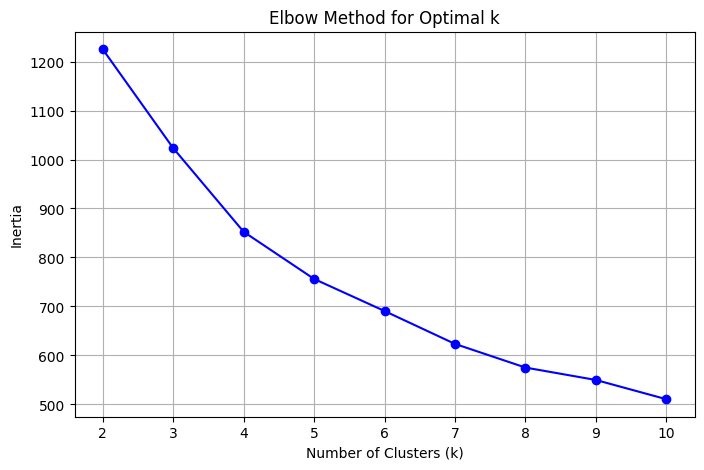

In [11]:
# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [12]:
# Apply KMeans clustering with k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)


In [13]:
# Add the cluster labels to the original customer features
customer_features['Cluster'] = clusters

In [14]:
# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(X_scaled, clusters)
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 1.360594417586387


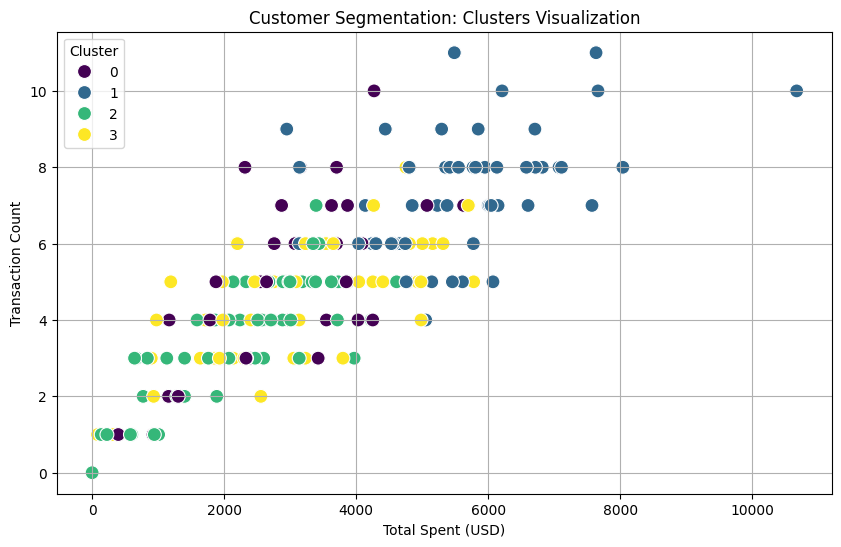

In [15]:
# Visualize clusters using two key features: total_spent and transaction_count
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_features,
    x='total_spent',
    y='transaction_count',
    hue='Cluster',
    palette='viridis',
    s=100
)
plt.title('Customer Segmentation: Clusters Visualization')
plt.xlabel('Total Spent (USD)')
plt.ylabel('Transaction Count')
plt.legend(title='Cluster')
plt.grid()
plt.show()
